In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/sample_submission.csv')

train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


In [2]:
# turn columns into datetime obj
train['MMM-YY'] = pd.to_datetime(train['MMM-YY'])
train['Dateofjoining'] = pd.to_datetime(train['Dateofjoining'])
train['LastWorkingDate'] = pd.to_datetime(train['LastWorkingDate'])

In [3]:
# add more features based on date
train['reporting_year'] = train['MMM-YY'].dt.year
train['reporting_month'] = train['MMM-YY'].dt.month
# train['reporting_day'] = train['MMM-YY'].dt.day (all are of value 1)
train['reporting_day_of_the_week'] = train['MMM-YY'].dt.dayofweek

train['joining_year'] = train['Dateofjoining'].dt.year
train['joining_month'] = train['Dateofjoining'].dt.month
train['joining_day'] = train['Dateofjoining'].dt.day
train['joining_day_of_the_week'] = train['Dateofjoining'].dt.dayofweek

train['days_bw'] = (train['MMM-YY'] - train['Dateofjoining']).dt.days
train['days_worked'] = (train['LastWorkingDate'] - train['Dateofjoining']).dt.days
train['days_worked'] = train['days_worked'].fillna(0)


# use 'LastWorkingDate' to get target column
train['target'] = np.where(train['LastWorkingDate'].isnull(), 0, 1)


In [4]:
train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,reporting_year,reporting_month,reporting_day_of_the_week,joining_year,joining_month,joining_day,joining_day_of_the_week,days_bw,days_worked,target
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2,2016,1,4,2015,12,24,3,8,0.0,0
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2,2016,2,0,2015,12,24,3,39,0.0,0
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,2016,3,1,2015,12,24,3,68,78.0,1
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1,2017,11,2,2017,11,6,0,-5,0.0,0
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1,2017,12,4,2017,11,6,0,25,0.0,0


In [5]:
# Filter test data using Emp_ID from train set and set aside for testing
val = test['Emp_ID'].values
df = train[(train.Emp_ID.isin(val))]
train = train.drop(df.index)


In [6]:
# Select attributes required for training the model

x_train = train[['Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating',
       'reporting_year', 'reporting_month',
       'reporting_day_of_the_week', 'joining_year', 'joining_month',
       'joining_day', 'joining_day_of_the_week', 'days_bw', 'target']]
x_test = df[['Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating',
       'reporting_year', 'reporting_month',
       'reporting_day_of_the_week', 'joining_year', 'joining_month',
       'joining_day', 'joining_day_of_the_week', 'days_bw']]

In [7]:
# sanity check
x_train.info(), x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10516 entries, 0 to 19096
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        10516 non-null  int64 
 1   Gender                     10516 non-null  object
 2   City                       10516 non-null  object
 3   Education_Level            10516 non-null  object
 4   Salary                     10516 non-null  int64 
 5   Joining Designation        10516 non-null  int64 
 6   Designation                10516 non-null  int64 
 7   Total Business Value       10516 non-null  int64 
 8   Quarterly Rating           10516 non-null  int64 
 9   reporting_year             10516 non-null  int64 
 10  reporting_month            10516 non-null  int64 
 11  reporting_day_of_the_week  10516 non-null  int64 
 12  joining_year               10516 non-null  int64 
 13  joining_month              10516 non-null  int64 
 14  joinin

(None, None)

#### Train model

In [8]:
!pip install tensorflow_decision_forests --quiet
!pip install wurlitzer --quiet
!pip install tensorflow_addons --quiet

import tensorflow_decision_forests as tfdf
from wurlitzer import sys_pipes
import tensorflow as tf
import tensorflow_addons as tfa

# Convert the dataset into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(x_train, label = 'target')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(x_test)



# Specify the model.
model_1 = tfdf.keras.RandomForestModel()

# Optionally, add evaluation metrics.
metric = tfa.metrics.F1Score(num_classes=2, average='macro')
model_1.compile(metrics=metric)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
  model_1.fit(x=train_ds)

153/165 [==========================>...] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 165
[INFO kernel.cc:393] Number of examples: 10516
[INFO kernel.cc:759] Dataset:
Number of records: 10516
Number of columns: 18

Number of columns by type:
	NUMERICAL: 14 (77.7778%)
	CATEGORICAL: 4 (22.2222%)

Columns:

NUMERICAL: 14 (77.7778%)
	0: "Age" NUMERICAL mean:33.8812 min:21 max:58 sd:6.22922
	2: "Designation" NUMERICAL mean:2.06238 min:1 max:5 sd:0.969832
	5: "Joining_Designation" NUMERICAL mean:1.70236 min:1 max:5 sd:0.834679
	6: "Quarterly_Rating" NUMERICAL mean:1.64464 min:1 max:4 sd:0.865586
	7: "Salary" NUMERICAL mean:59380.2 min:10747 max:167758 sd:28707
	8: "Total_Business_Value" NUMERICAL mean:343717 min:-6e+06 max:1.60794e+07 sd:796796
	9: "days_bw" NUMERICAL mean:425.353 min:-27 max:2583 sd:536.183
	10: "joining_day" NUMERICAL mean:15.7206 min:1 max:31 sd:9.10697
	11: "joining_day_of_the_week" NUMERICAL mean:1.91508 min:0 max:5 s

165/165 [==============================] - 13s 42ms/step


In [9]:
# Find imp attributes learnt by the model
model_1.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (17):
	Age
	City
	Designation
	Education_Level
	Gender
	Joining_Designation
	Quarterly_Rating
	Salary
	Total_Business_Value
	days_bw
	joining_day
	joining_day_of_the_week
	joining_month
	joining_year
	reporting_day_of_the_week
	reporting_month
	reporting_year

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                   "__LABEL" 11.450388 ################
    2.                    "Gender" 11.218159 ###############
    3.           "Education_Level" 10.905688 ###############
    4.   "joining_day_of_the_week" 10.577329 ##############
    5.       "Joining_Designation" 10.302124 #############
    6.             "join

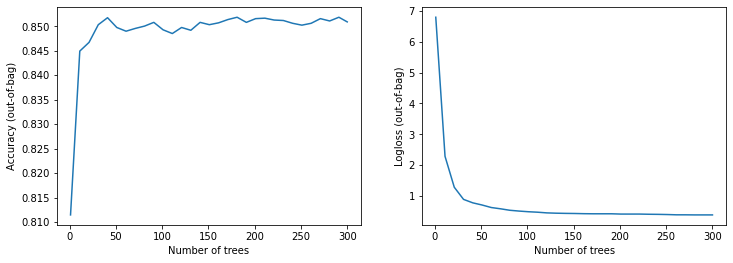

In [10]:
#plot
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

#### Predict results using trained model

In [11]:
pred = model_1.predict(test_ds)

# get id column back from test set (which was split from train set initially)
x_test['pred'] = pred
x_test['ID'] = df['Emp_ID']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [12]:
ans = x_test[['ID','pred']]
ans.head()

,ID,pred
3,2,0.040000
4,2,0.213333
13,6,0.046667
14,6,0.256667
15,6,0.076667


In [13]:
# group by to get one prediction per ID
ans = ans.groupby(["ID"])["pred"].max().reset_index()
ans.head()

,ID,pred
0,2,0.213333
1,6,0.476666
2,11,0.166667
3,14,0.393333
4,25,0.303333


In [14]:
# If prob is > 0.5 for ID then value is labelled 1, else 0)
ans['val'] = np.where(ans['pred']> 0.5, 1, 0)
ans.head()

,ID,pred,val
0,2,0.213333,0
1,6,0.476666,0
2,11,0.166667,0
3,14,0.393333,0
4,25,0.303333,0


In [15]:
# get values based on test set index for final submission
sub_test = pd.merge(test, ans, how='left', left_on='Emp_ID', right_on='ID')
sub_test.head()

,Emp_ID,ID,pred,val
0,394,394,0.323333,0
1,173,173,0.356666,0
2,1090,1090,0.456666,0
3,840,840,0.353333,0
4,308,308,0.360000,0


In [16]:
sub['Target'] = sub_test.val
sub = sub.set_index('Emp_ID')
sub.head()

,Target
Emp_ID,
394,0
173,0
1090,0
840,0
308,0


In [17]:
# Save results to csv file
sub.to_csv('sub3.csv')

##Thanks for reading.